In [1]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Libraries imported successfully!")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 Plotly version: {plotly.__version__}")

✅ Libraries imported successfully!
📦 Pandas version: 2.3.0
📦 Plotly version: 6.3.1


In [2]:
# Cell 2: Load parking occupancy data
CSV_PATH = r"C:\Users\ertugrul\Downloads\Parking_Occupancy_Oct_28-29_2025.csv"

# Read CSV
df = pd.read_csv(CSV_PATH)

print("=" * 70)
print("🅿️ PARKING DATASET OVERVIEW")
print("=" * 70)
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique parking bays: {df['kerbsideid'].nunique()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "=" * 70)
print("📋 COLUMN NAMES")
print("=" * 70)
print(df.columns.tolist())

print("\n" + "=" * 70)
print("🔍 FIRST 5 ROWS")
print("=" * 70)
print(df.head())

print("\n" + "=" * 70)
print("📈 DATA TYPES")
print("=" * 70)
print(df.dtypes)

print("\n" + "=" * 70)
print("📊 BASIC STATISTICS")
print("=" * 70)
print(df[['hour', 'is_occupied', 'latitude', 'longitude']].describe())

🅿️ PARKING DATASET OVERVIEW
Total rows: 56,849
Total columns: 19
Date range: 2025-10-28 to 2025-10-29
Unique parking bays: 1916
Memory usage: 23.76 MB

📋 COLUMN NAMES
['sensor_id', 'zone_number', 'kerbsideid', 'status_description', 'melbourne_time', 'date', 'day_name', 'hour', 'day_of_week', 'time_of_day', 'is_occupied', 'sensor_latitude', 'sensor_longitude', 'roadsegmentid', 'street_name', 'bay_latitude', 'bay_longitude', 'latitude', 'longitude']

🔍 FIRST 5 ROWS
   sensor_id  zone_number  kerbsideid status_description       melbourne_time  \
0      14222         7455       61412         Unoccupied  2025-10-28 22:20:33   
1      14223         7639       52228         Unoccupied  2025-10-28 22:22:29   
2      14224         7635       52319            Present  2025-10-28 22:21:58   
3      14225         7487       56828         Unoccupied  2025-10-28 22:20:20   
4      14226         7696       53913         Unoccupied  2025-10-28 22:20:08   

         date   day_name  hour  day_of_week t

In [3]:
# Cell 3: Clean and prepare parking data

# Convert melbourne_time to datetime
df['melbourne_time'] = pd.to_datetime(df['melbourne_time'])
df['date'] = pd.to_datetime(df['date'])

# Ensure numeric columns
df['hour'] = pd.to_numeric(df['hour'], errors='coerce')
df['is_occupied'] = pd.to_numeric(df['is_occupied'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Remove rows with missing critical data
df = df.dropna(subset=['is_occupied'])

# Create additional features
df['hour_label'] = df['hour'].apply(lambda x: f"{int(x):02d}:00")
df['is_peak_hour'] = df['hour'].isin([8, 9, 12, 13, 17, 18])
df['is_business_hours'] = df['hour'].between(9, 17)

# Clean day_name (remove extra spaces)
df['day_name'] = df['day_name'].str.strip()

# Calculate occupancy rate (percentage)
df['occupancy_pct'] = df['is_occupied'] * 100

print("✅ Data cleaning complete!")
print(f"Rows after cleaning: {len(df):,}")
print(f"\nStatus distribution:")
print(df['status_description'].value_counts())
print(f"\nOccupancy rate: {df['is_occupied'].mean() * 100:.2f}%")
print(f"\nMissing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

✅ Data cleaning complete!
Rows after cleaning: 56,849

Status distribution:
status_description
Unoccupied    30150
Present       26699
Name: count, dtype: int64

Occupancy rate: 46.96%

Missing values:
roadsegmentid    54317
street_name      54317
bay_latitude     54317
bay_longitude    54317
dtype: int64


In [4]:
# Cell 4: Summary by day and hour

print("=" * 70)
print("📅 DAILY PARKING SUMMARY")
print("=" * 70)

daily_summary = df.groupby('date').agg({
    'sensor_id': 'count',
    'kerbsideid': 'nunique',
    'is_occupied': ['sum', 'mean'],
    'melbourne_time': ['min', 'max']
}).round(2)

daily_summary.columns = ['Total Readings', 'Unique Bays', 'Occupied Count', 
                         'Occupancy Rate', 'First Reading', 'Last Reading']
daily_summary['Occupancy Rate'] = (daily_summary['Occupancy Rate'] * 100).round(2).astype(str) + '%'
print(daily_summary)

print("\n" + "=" * 70)
print("🕐 HOURLY OCCUPANCY AVERAGE (ALL DAYS)")
print("=" * 70)

hourly_avg = df.groupby('hour').agg({
    'is_occupied': ['mean', 'count'],
    'kerbsideid': 'nunique'
}).round(4)

hourly_avg.columns = ['Occupancy Rate', 'Total Readings', 'Active Bays']
hourly_avg['Occupancy Rate'] = (hourly_avg['Occupancy Rate'] * 100).round(2)
hourly_avg.index.name = 'Hour'
print(hourly_avg)

print("\n" + "=" * 70)
print("🏆 TOP 10 BUSIEST PARKING LOCATIONS")
print("=" * 70)

top_locations = df.groupby(['kerbsideid', 'street_name']).agg({
    'is_occupied': ['sum', 'mean', 'count'],
}).round(2)

top_locations.columns = ['Times Occupied', 'Avg Occupancy Rate', 'Total Readings']
top_locations['Avg Occupancy Rate'] = (top_locations['Avg Occupancy Rate'] * 100).round(2)
top_locations = top_locations.sort_values('Times Occupied', ascending=False).head(10)
print(top_locations)

📅 DAILY PARKING SUMMARY
            Total Readings  Unique Bays  Occupied Count Occupancy Rate  \
date                                                                     
2025-10-28            6721         1846            3037          45.0%   
2025-10-29           50128         1886           23662          47.0%   

                 First Reading        Last Reading  
date                                                
2025-10-28 2025-10-28 05:33:50 2025-10-28 23:59:57  
2025-10-29 2025-10-29 00:00:08 2025-10-29 23:59:56  

🕐 HOURLY OCCUPANCY AVERAGE (ALL DAYS)
      Occupancy Rate  Total Readings  Active Bays
Hour                                             
0              37.06             831          432
1              37.86             523          306
2              28.01             332          257
3              31.14             350          254
4              45.34             494          289
5              51.18             936          483
6              49.06        

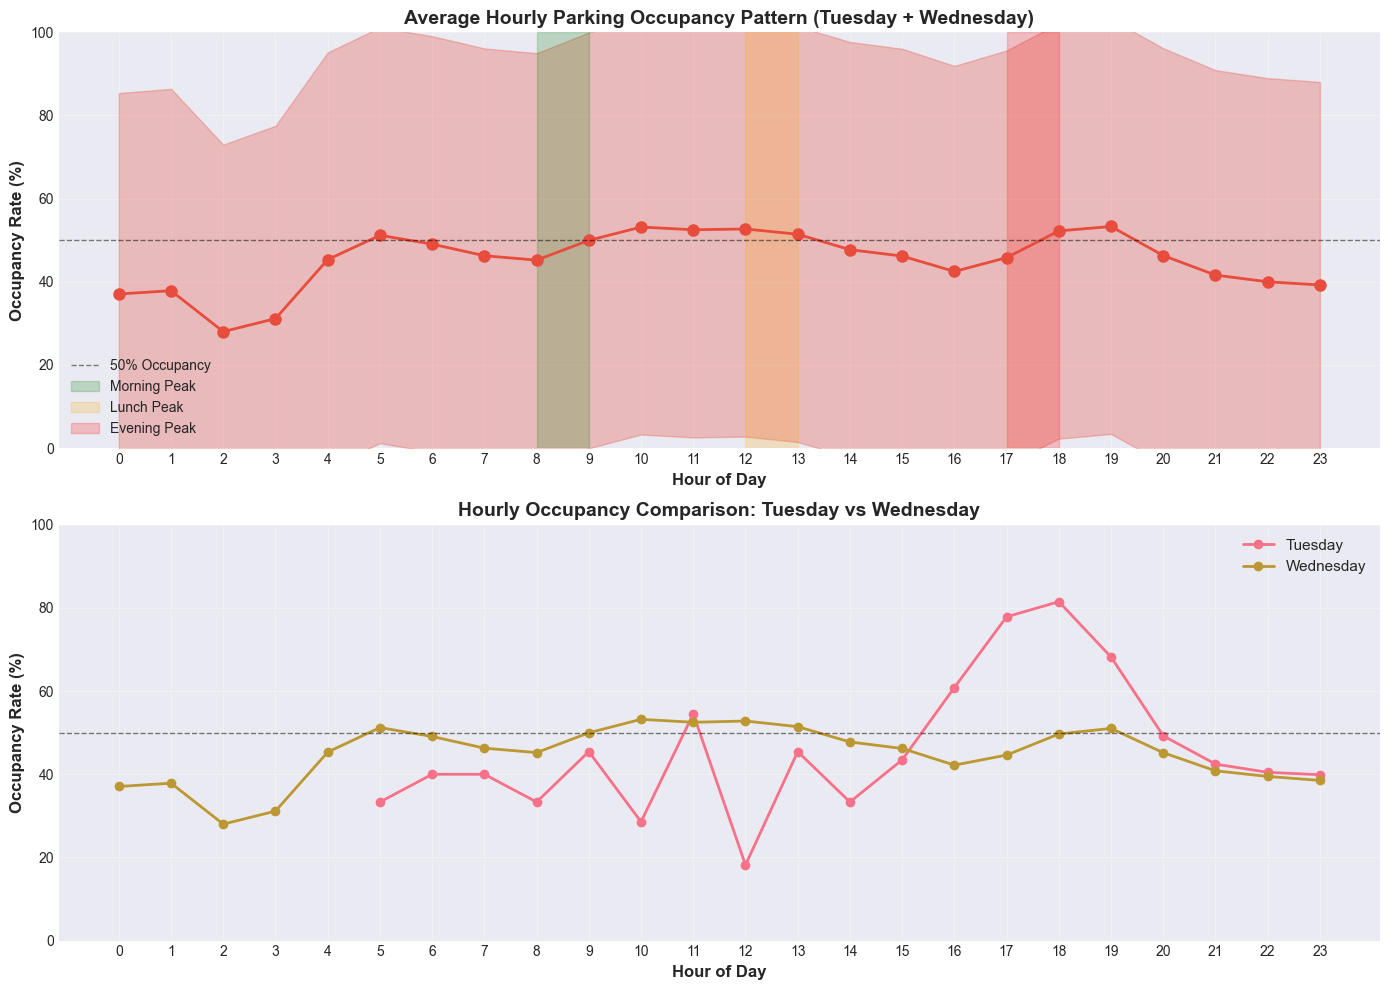

✅ Hourly occupancy chart saved as 'parking_hourly_occupancy.png'


In [5]:
# Cell 5: Hourly occupancy pattern visualization

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Average occupancy rate by hour (both days combined)
hourly_occupancy = df.groupby('hour').agg({
    'is_occupied': ['mean', 'std']
}).reset_index()
hourly_occupancy.columns = ['hour', 'mean', 'std']
hourly_occupancy['mean'] = hourly_occupancy['mean'] * 100  # Convert to percentage
hourly_occupancy['std'] = hourly_occupancy['std'] * 100

axes[0].plot(hourly_occupancy['hour'], hourly_occupancy['mean'], 
             marker='o', linewidth=2, markersize=8, color='#E74C3C')
axes[0].fill_between(hourly_occupancy['hour'], 
                      hourly_occupancy['mean'] - hourly_occupancy['std'], 
                      hourly_occupancy['mean'] + hourly_occupancy['std'], 
                      alpha=0.3, color='#E74C3C')
axes[0].set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Occupancy Rate (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Average Hourly Parking Occupancy Pattern (Tuesday + Wednesday)', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24))
axes[0].axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% Occupancy')
axes[0].axvspan(8, 9, alpha=0.2, color='green', label='Morning Peak')
axes[0].axvspan(12, 13, alpha=0.2, color='orange', label='Lunch Peak')
axes[0].axvspan(17, 18, alpha=0.2, color='red', label='Evening Peak')
axes[0].legend()
axes[0].set_ylim(0, 100)

# Plot 2: Compare Tuesday vs Wednesday
hourly_by_day = df.groupby(['day_name', 'hour'])['is_occupied'].mean().reset_index()
hourly_by_day['is_occupied'] = hourly_by_day['is_occupied'] * 100

for day in hourly_by_day['day_name'].unique():
    day_data = hourly_by_day[hourly_by_day['day_name'] == day]
    axes[1].plot(day_data['hour'], day_data['is_occupied'], 
                 marker='o', label=day, linewidth=2, markersize=6)

axes[1].set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Occupancy Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Hourly Occupancy Comparison: Tuesday vs Wednesday', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(0, 24))
axes[1].axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].legend(fontsize=11)
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.savefig('parking_hourly_occupancy.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Hourly occupancy chart saved as 'parking_hourly_occupancy.png'")

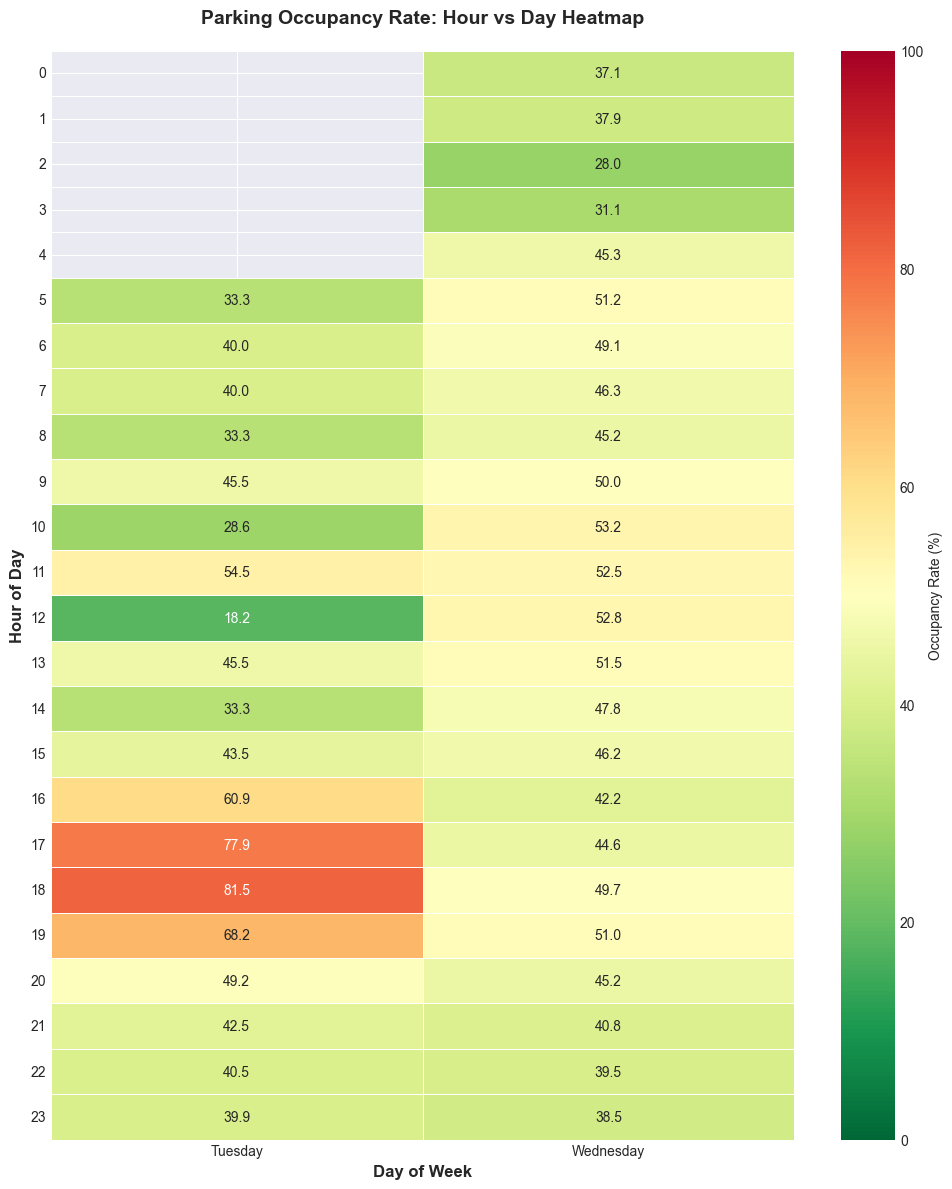

✅ Heatmap saved as 'parking_heatmap_hour_vs_day.png'


In [6]:
# Cell 6: Heatmap showing occupancy by hour and day

# Create pivot table for heatmap
heatmap_data = df.pivot_table(
    values='is_occupied',
    index='hour',
    columns='day_name',
    aggfunc='mean'
) * 100  # Convert to percentage

plt.figure(figsize=(10, 12))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Occupancy Rate (%)'}, linewidths=0.5,
            vmin=0, vmax=100)
plt.title('Parking Occupancy Rate: Hour vs Day Heatmap', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Day of Week', fontsize=12, fontweight='bold')
plt.ylabel('Hour of Day', fontsize=12, fontweight='bold')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('parking_heatmap_hour_vs_day.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Heatmap saved as 'parking_heatmap_hour_vs_day.png'")

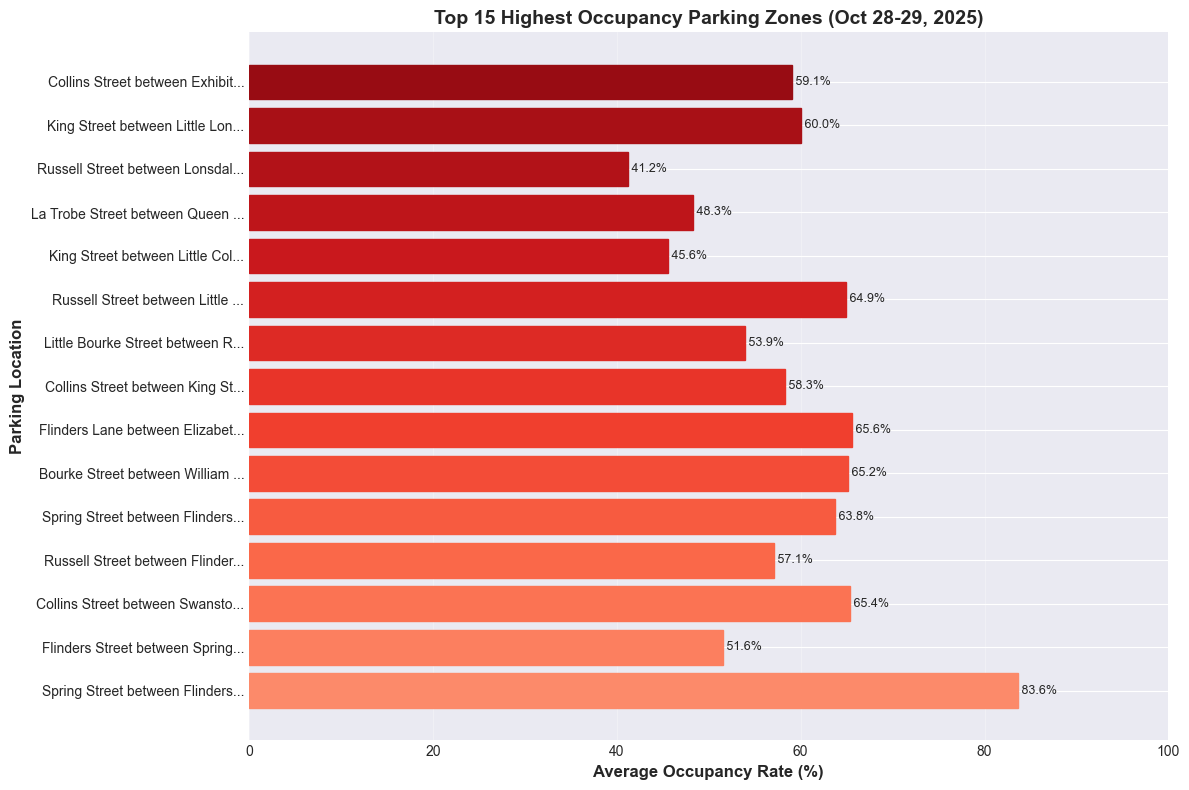

✅ Top zones chart saved as 'parking_top15_busiest_zones.png'


In [7]:
# Cell 7: Top 15 busiest parking zones

top15_zones = df.groupby(['street_name', 'kerbsideid']).agg({
    'is_occupied': ['sum', 'mean', 'count']
}).reset_index()

top15_zones.columns = ['street_name', 'kerbsideid', 'times_occupied', 'avg_occupancy', 'total_readings']
top15_zones['avg_occupancy'] = top15_zones['avg_occupancy'] * 100
top15_zones = top15_zones.sort_values('times_occupied', ascending=False).head(15)

# Create labels
top15_zones['label'] = top15_zones.apply(
    lambda row: f"{row['street_name'][:30]}..." if len(str(row['street_name'])) > 30 
    else str(row['street_name']), axis=1
)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top15_zones)), top15_zones['avg_occupancy'])

# Color code by occupancy rate
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(top15_zones)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.yticks(range(len(top15_zones)), top15_zones['label'])
plt.xlabel('Average Occupancy Rate (%)', fontsize=12, fontweight='bold')
plt.ylabel('Parking Location', fontsize=12, fontweight='bold')
plt.title('Top 15 Highest Occupancy Parking Zones (Oct 28-29, 2025)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, 100)

# Add value labels on bars
for i, (idx, row) in enumerate(top15_zones.iterrows()):
    plt.text(row['avg_occupancy'], i, f" {row['avg_occupancy']:.1f}%", 
             va='center', fontsize=9)

plt.tight_layout()
plt.savefig('parking_top15_busiest_zones.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Top zones chart saved as 'parking_top15_busiest_zones.png'")

In [8]:
# Cell 8: Interactive parking map with Mapbox

# Aggregate parking bay data for mapping
parking_summary = df.groupby(['kerbsideid', 'street_name', 'latitude', 'longitude']).agg({
    'is_occupied': ['sum', 'mean', 'count']
}).reset_index()

parking_summary.columns = ['kerbsideid', 'street_name', 'latitude', 'longitude', 
                           'times_occupied', 'avg_occupancy_rate', 'total_readings']

# Convert to percentage
parking_summary['avg_occupancy_rate'] = parking_summary['avg_occupancy_rate'] * 100

# Remove bays without coordinates
parking_summary = parking_summary.dropna(subset=['latitude', 'longitude'])

# Create hover text
parking_summary['hover_text'] = parking_summary.apply(
    lambda row: f"<b>{row['street_name']}</b><br>" +
                f"Bay ID: {row['kerbsideid']}<br>" +
                f"Avg Occupancy: {row['avg_occupancy_rate']:.1f}%<br>" +
                f"Times Occupied: {int(row['times_occupied']):,}<br>" +
                f"Total Readings: {int(row['total_readings']):,}",
    axis=1
)

# Create Mapbox scatter plot
fig = px.scatter_mapbox(
    parking_summary,
    lat='latitude',
    lon='longitude',
    size='total_readings',
    color='avg_occupancy_rate',
    hover_name='street_name',
    hover_data={
        'kerbsideid': True,
        'avg_occupancy_rate': ':.1f',
        'times_occupied': ':,',
        'total_readings': ':,',
        'latitude': False,
        'longitude': False
    },
    color_continuous_scale='RdYlGn_r',
    size_max=15,
    zoom=12,
    height=700,
    title='Melbourne Parking Occupancy Map (Oct 28-29, 2025)',
    labels={'avg_occupancy_rate': 'Avg Occupancy (%)'}
)

fig.update_layout(
    mapbox_style="dark",
    mapbox_accesstoken="pk.eyJ1IjoiZXJ0dWdydWxha2RlbWlyIiwiYSI6ImNtZ3o0NXVsOTAyOXk3cHM4ZHJ0MmU1enMifQ.vj7BMAX9VFQbNGaqt9ixdQ",
    font=dict(size=12),
    title_font_size=16,
    coloraxis_colorbar=dict(title="Occupancy %")
)

fig.show()

# Save as HTML
fig.write_html('parking_occupancy_map.html')
print("✅ Interactive map saved as 'parking_occupancy_map.html'")
print("📍 Open the HTML file in your browser to interact with the map")

✅ Interactive map saved as 'parking_occupancy_map.html'
📍 Open the HTML file in your browser to interact with the map


🔥 PEAK HOURS PARKING ANALYSIS

📊 Morning Rush (8 AM)
   Total readings: 2,597
   Active parking bays: 929
   Times occupied: 1,174
   Occupancy rate: 45.21%
   Top 3 most occupied streets:
      • Flinders Lane between Spring Street and Exhibition Street: 100.0% occupancy
      • Collins Street between Swanston Street and Elizabeth Street: 100.0% occupancy
      • Cobden Street between Victoria Street and Princess Street: 100.0% occupancy

📊 Lunch Peak (12 PM)
   Total readings: 3,338
   Active parking bays: 1075
   Times occupied: 1,759
   Occupancy rate: 52.70%
   Top 3 most occupied streets:
      • Collins Street between Swanston Street and Elizabeth Street: 100.0% occupancy
      • Collins Street between King Street and Spencer Street: 100.0% occupancy
      • Church Street between Bourke Street and Little Collins Street: 100.0% occupancy

📊 Evening Rush (5 PM)
   Total readings: 2,910
   Active parking bays: 1104
   Times occupied: 1,333
   Occupancy rate: 45.81%
   Top 3 most oc

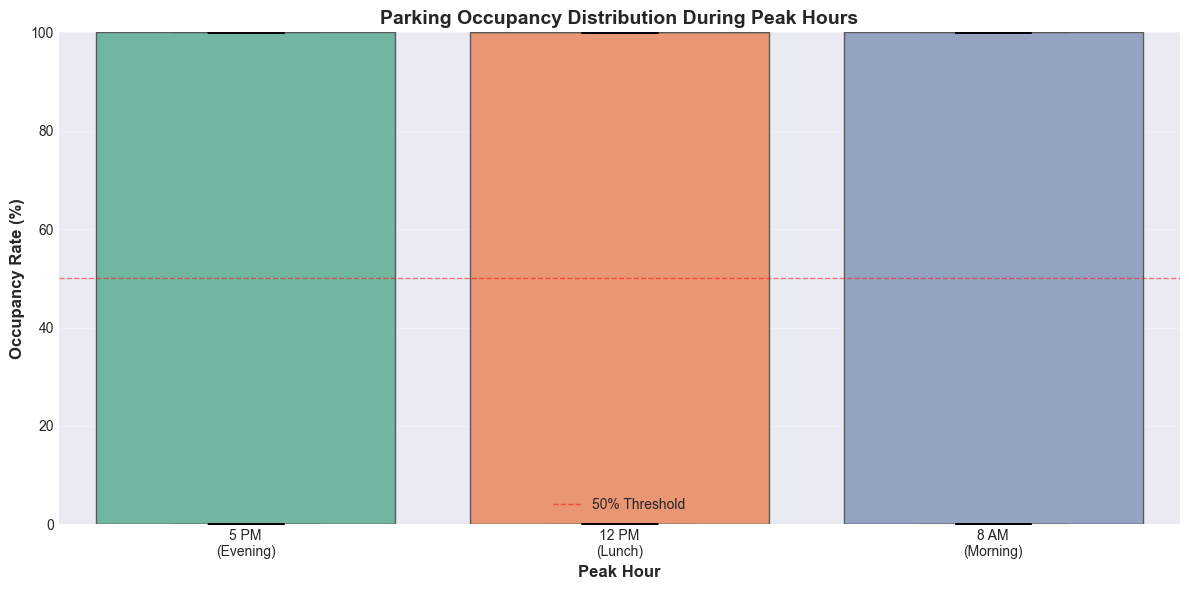


✅ Peak hours analysis chart saved as 'parking_peak_hours_comparison.png'


In [9]:
# Cell 9: Peak hours parking demand analysis

print("=" * 70)
print("🔥 PEAK HOURS PARKING ANALYSIS")
print("=" * 70)

peak_hours = [8, 12, 17]
peak_names = ['Morning Rush (8 AM)', 'Lunch Peak (12 PM)', 'Evening Rush (5 PM)']

for hour, name in zip(peak_hours, peak_names):
    hour_data = df[df['hour'] == hour]
    
    print(f"\n📊 {name}")
    print(f"   Total readings: {len(hour_data):,}")
    print(f"   Active parking bays: {hour_data['kerbsideid'].nunique()}")
    print(f"   Times occupied: {hour_data['is_occupied'].sum():,}")
    print(f"   Occupancy rate: {hour_data['is_occupied'].mean() * 100:.2f}%")
    
    # Top 3 most occupied locations during this hour
    top3 = hour_data.groupby('street_name')['is_occupied'].mean().sort_values(ascending=False).head(3)
    print(f"   Top 3 most occupied streets:")
    for street, rate in top3.items():
        print(f"      • {street}: {rate * 100:.1f}% occupancy")

# Visualize peak hours comparison
peak_data = df[df['hour'].isin(peak_hours)].copy()
peak_data['hour_label'] = peak_data['hour'].map({8: '8 AM\n(Morning)', 
                                                   12: '12 PM\n(Lunch)', 
                                                   17: '5 PM\n(Evening)'})

plt.figure(figsize=(12, 6))
sns.boxplot(data=peak_data, x='hour_label', y='occupancy_pct', palette='Set2')
sns.stripplot(data=peak_data, x='hour_label', y='occupancy_pct', 
              color='black', alpha=0.2, size=2)

plt.title('Parking Occupancy Distribution During Peak Hours', 
          fontsize=14, fontweight='bold')
plt.xlabel('Peak Hour', fontsize=12, fontweight='bold')
plt.ylabel('Occupancy Rate (%)', fontsize=12, fontweight='bold')
plt.ylim(0, 100)
plt.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% Threshold')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('parking_peak_hours_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Peak hours analysis chart saved as 'parking_peak_hours_comparison.png'")

🌅 TIME OF DAY PARKING SUMMARY
             Times Occupied  Avg Occupancy Rate  Total Readings  Active Bays
time_of_day                                                                 
Morning                7854               49.71           15799         1702
Afternoon              9344               47.90           19508         1744
Evening                5561               47.52           11702         1814
Night                  3940               40.04            9840         1499


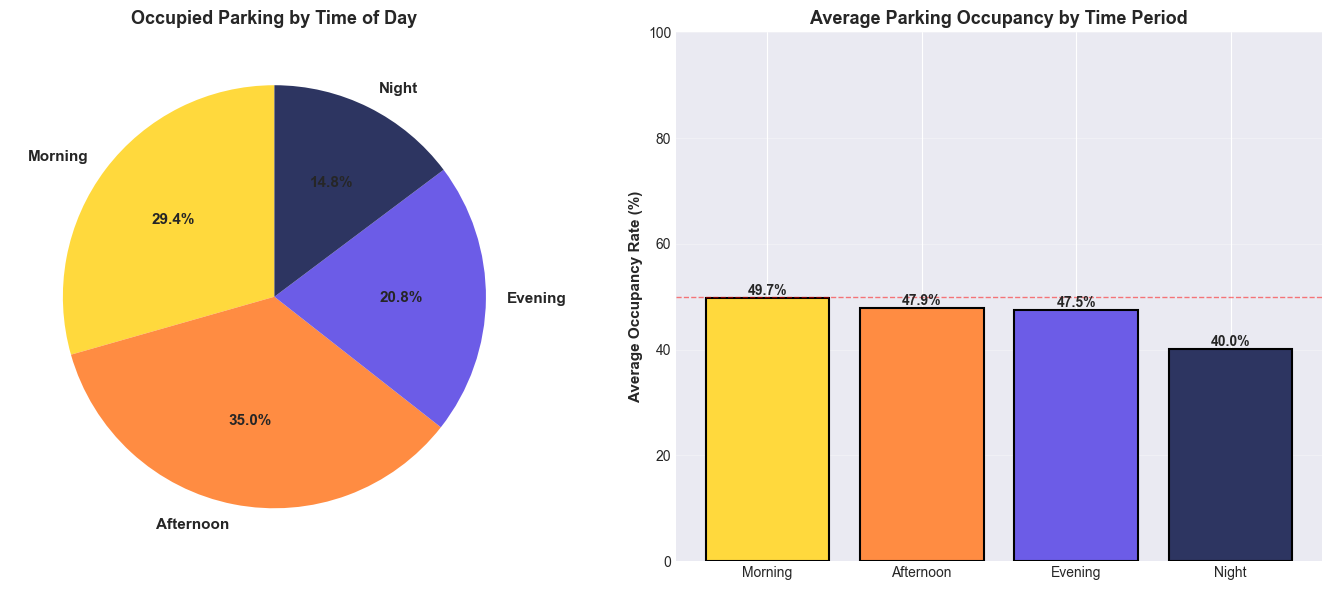


✅ Time of day analysis saved as 'parking_time_of_day_analysis.png'


In [10]:
# Cell 10: Time of day parking patterns

time_of_day_summary = df.groupby('time_of_day').agg({
    'is_occupied': ['sum', 'mean', 'count'],
    'kerbsideid': 'nunique'
}).round(4)

time_of_day_summary.columns = ['Times Occupied', 'Avg Occupancy Rate', 'Total Readings', 'Active Bays']
time_of_day_summary['Avg Occupancy Rate'] = (time_of_day_summary['Avg Occupancy Rate'] * 100).round(2)

# Order by time of day
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
time_of_day_summary = time_of_day_summary.reindex(time_order)

print("=" * 70)
print("🌅 TIME OF DAY PARKING SUMMARY")
print("=" * 70)
print(time_of_day_summary)

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart 1: Occupied readings by time of day
time_occupied = df.groupby('time_of_day')['is_occupied'].sum().reindex(time_order)

colors = ['#FFD93D', '#FF8C42', '#6C5CE7', '#2D3561']
ax1.pie(time_occupied, labels=time_order, autopct='%1.1f%%', colors=colors,
        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Occupied Parking by Time of Day', 
              fontsize=13, fontweight='bold')

# Bar chart 2: Average occupancy rate by time of day
time_avg = df.groupby('time_of_day')['is_occupied'].mean().reindex(time_order) * 100
bars = ax2.bar(time_order, time_avg, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Average Occupancy Rate (%)', fontsize=11, fontweight='bold')
ax2.set_title('Average Parking Occupancy by Time Period', 
              fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 100)
ax2.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('parking_time_of_day_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Time of day analysis saved as 'parking_time_of_day_analysis.png'")

In [11]:
# Cell 11: Key insights and parking statistics

print("=" * 70)
print("🎯 KEY PARKING INSIGHTS & FINDINGS")
print("=" * 70)

# 1. Peak occupancy hour
peak_hour = df.groupby('hour')['is_occupied'].mean().idxmax()
peak_hour_rate = df.groupby('hour')['is_occupied'].mean().max() * 100

print(f"\n📊 PEAK OCCUPANCY")
print(f"   • Peak hour: {int(peak_hour)}:00 ({peak_hour_rate:.1f}% occupancy)")

# 2. Lowest occupancy hour
low_hour = df.groupby('hour')['is_occupied'].mean().idxmin()
low_hour_rate = df.groupby('hour')['is_occupied'].mean().min() * 100

print(f"\n🆓 BEST TIME TO FIND PARKING")
print(f"   • Best hour: {int(low_hour)}:00 ({low_hour_rate:.1f}% occupancy)")

# 3. Most occupied parking zone
busiest_zone = df.groupby('street_name')['is_occupied'].sum().idxmax()
busiest_count = df.groupby('street_name')['is_occupied'].sum().max()

print(f"\n🏆 MOST IN-DEMAND PARKING ZONE")
print(f"   • {busiest_zone}")
print(f"   • Total times occupied: {int(busiest_count):,}")

# 4. Day comparison
day_comparison = df.groupby('day_name')['is_occupied'].agg(['sum', 'mean'])
day_comparison['mean'] = day_comparison['mean'] * 100
print(f"\n📅 DAY COMPARISON")
for day in day_comparison.index:
    print(f"   • {day}: {int(day_comparison.loc[day, 'sum']):,} occupied readings, " +
          f"{day_comparison.loc[day, 'mean']:.1f}% avg occupancy")

# 5. Business hours vs non-business
business_hours_occ = df[df['is_business_hours']]['is_occupied'].mean() * 100
non_business_occ = df[~df['is_business_hours']]['is_occupied'].mean() * 100

print(f"\n⏰ BUSINESS HOURS (9 AM - 5 PM)")
print(f"   • Business hours occupancy: {business_hours_occ:.1f}%")
print(f"   • Non-business hours occupancy: {non_business_occ:.1f}%")
print(f"   • Difference: {abs(business_hours_occ - non_business_occ):.1f}% {'higher' if business_hours_occ > non_business_occ else 'lower'} during business hours")

# 6. Overall statistics
print(f"\n✅ DATA QUALITY")
print(f"   • Total readings: {len(df):,}")
print(f"   • Unique parking bays: {df['kerbsideid'].nunique()}")
print(f"   • Date range: {df['date'].min()} to {df['date'].max()}")
print(f"   • Hours covered: {df['hour'].nunique()} out of 24")
print(f"   • Overall occupancy rate: {df['is_occupied'].mean() * 100:.2f}%")
print(f"   • Missing coordinates: {df['latitude'].isna().sum()}")

# 7. Parking availability insights
total_readings = len(df)
vacant_readings = (df['is_occupied'] == 0).sum()
occupied_readings = (df['is_occupied'] == 1).sum()

print(f"\n🅿️ PARKING AVAILABILITY")
print(f"   • Vacant readings: {vacant_readings:,} ({vacant_readings/total_readings*100:.1f}%)")
print(f"   • Occupied readings: {occupied_readings:,} ({occupied_readings/total_readings*100:.1f}%)")

print("\n" + "=" * 70)
print("✅ PARKING ANALYSIS COMPLETE!")
print("=" * 70)

🎯 KEY PARKING INSIGHTS & FINDINGS

📊 PEAK OCCUPANCY
   • Peak hour: 19:00 (53.3% occupancy)

🆓 BEST TIME TO FIND PARKING
   • Best hour: 2:00 (28.0% occupancy)

🏆 MOST IN-DEMAND PARKING ZONE
   • Spring Street between Flinders Lane and Collins Street
   • Total times occupied: 148

📅 DAY COMPARISON
   • Tuesday: 3,037 occupied readings, 45.2% avg occupancy
   • Wednesday: 23,662 occupied readings, 47.2% avg occupancy

⏰ BUSINESS HOURS (9 AM - 5 PM)
   • Business hours occupancy: 49.2%
   • Non-business hours occupancy: 44.7%
   • Difference: 4.5% higher during business hours

✅ DATA QUALITY
   • Total readings: 56,849
   • Unique parking bays: 1916
   • Date range: 2025-10-28 00:00:00 to 2025-10-29 00:00:00
   • Hours covered: 24 out of 24
   • Overall occupancy rate: 46.96%
   • Missing coordinates: 0

🅿️ PARKING AVAILABILITY
   • Vacant readings: 30,150 (53.0%)
   • Occupied readings: 26,699 (47.0%)

✅ PARKING ANALYSIS COMPLETE!


In [12]:
# Cell 12: Animated hourly parking occupancy map

# Aggregate by hour for animation
hourly_map_data = df.groupby(['hour', 'kerbsideid', 'street_name', 'latitude', 'longitude']).agg({
    'is_occupied': 'mean'
}).reset_index()

# Convert to percentage
hourly_map_data['occupancy_rate'] = hourly_map_data['is_occupied'] * 100

# Remove bays without coordinates
hourly_map_data = hourly_map_data.dropna(subset=['latitude', 'longitude'])

# Create animated map
fig = px.scatter_mapbox(
    hourly_map_data,
    lat='latitude',
    lon='longitude',
    size='occupancy_rate',
    color='occupancy_rate',
    hover_name='street_name',
    hover_data={
        'kerbsideid': True,
        'occupancy_rate': ':.1f',
        'latitude': False,
        'longitude': False
    },
    animation_frame='hour',
    color_continuous_scale='RdYlGn_r',
    size_max=25,
    zoom=12,
    height=700,
    title='Melbourne Parking Occupancy - Hourly Animation',
    labels={'occupancy_rate': 'Occupancy (%)'},
    range_color=[0, 100]
)

fig.update_layout(
    mapbox_style="dark",
    mapbox_accesstoken="pk.eyJ1IjoiZXJ0dWdydWxha2RlbWlyIiwiYSI6ImNtZ3o0NXVsOTAyOXk3cHM4ZHJ0MmU1enMifQ.vj7BMAX9VFQbNGaqt9ixdQ",
    font=dict(size=12),
    title_font_size=16,
    coloraxis_colorbar=dict(title="Occupancy %")
)

fig.show()
fig.write_html('parking_occupancy_animated.html')
print("✅ Animated parking map saved as 'parking_occupancy_animated.html'")
print("🎬 Watch parking demand change throughout the day!")

✅ Animated parking map saved as 'parking_occupancy_animated.html'
🎬 Watch parking demand change throughout the day!


In [23]:
# Cell 12 (FIXED): Animated hourly parking occupancy map - ALL LOCATIONS

import pandas as pd
import plotly.express as px
from itertools import product

# Load all parking bays metadata
PARKING_BAYS_CSV = r"C:\Users\ertugrul\Downloads\parking_bays_rows.csv"
parking_bays_all = pd.read_csv(PARKING_BAYS_CSV)

# Clean coordinates
parking_bays_all['latitude'] = pd.to_numeric(parking_bays_all['latitude'], errors='coerce')
parking_bays_all['longitude'] = pd.to_numeric(parking_bays_all['longitude'], errors='coerce')
parking_bays_all = parking_bays_all.dropna(subset=['latitude', 'longitude'])

# Get unique locations (deduplicate by lat/lon, not kerbsideid)
unique_locations = parking_bays_all[['latitude', 'longitude', 'roadsegmentdescription']].drop_duplicates(
    subset=['latitude', 'longitude']
)

print(f"📍 Preparing animation for {len(unique_locations):,} unique parking locations...")

# Clean sensor data coordinates
df_clean = df.dropna(subset=['latitude', 'longitude']).copy()

# Aggregate sensor data by hour and lat/lon
hourly_sensor_data = df_clean.groupby(['hour', 'latitude', 'longitude']).agg({
    'is_occupied': 'mean',
    'street_name': 'first'
}).reset_index()
hourly_sensor_data['occupancy_rate'] = hourly_sensor_data['is_occupied'] * 100

print(f"   Sensor data locations: {hourly_sensor_data[['latitude', 'longitude']].drop_duplicates().shape[0]:,}")

# Create complete grid: all hours × all unique locations
all_hours = list(range(24))
complete_grid = pd.DataFrame(
    list(product(all_hours, zip(unique_locations['latitude'], unique_locations['longitude']))),
    columns=['hour', 'coords']
)
complete_grid[['latitude', 'longitude']] = pd.DataFrame(
    complete_grid['coords'].tolist(), 
    index=complete_grid.index
)
complete_grid = complete_grid.drop('coords', axis=1)

print(f"   Grid created: {len(complete_grid):,} rows (before merges)")

# Merge with location names
complete_grid = complete_grid.merge(
    unique_locations[['latitude', 'longitude', 'roadsegmentdescription']],
    on=['latitude', 'longitude'],
    how='left'
)

# Merge with actual occupancy data
complete_grid = complete_grid.merge(
    hourly_sensor_data[['hour', 'latitude', 'longitude', 'occupancy_rate']],
    on=['hour', 'latitude', 'longitude'],
    how='left'
)

# Fill missing occupancy data with 0 (no sensor data = vacant/unknown)
complete_grid['occupancy_rate'] = complete_grid['occupancy_rate'].fillna(0)

# Add status indicator
complete_grid['status'] = complete_grid['occupancy_rate'].apply(
    lambda x: 'No Data' if x == 0 else f'{x:.1f}% Occupied'
)

# Add size column (ensure dots show even with 0 occupancy)
complete_grid['dot_size'] = complete_grid['occupancy_rate'].apply(
    lambda x: 5 if x == 0 else max(x/5, 5)  # Minimum size 5
)

print(f"✅ Complete grid prepared: {len(complete_grid):,} rows")
print(f"   Sample rows:")
print(complete_grid.head())
print(f"   Occupancy rate range: {complete_grid['occupancy_rate'].min():.1f}% to {complete_grid['occupancy_rate'].max():.1f}%")
print(f"   Non-zero occupancy rows: {(complete_grid['occupancy_rate'] > 0).sum():,}")

# Create animated map
fig = px.scatter_mapbox(
    complete_grid,
    lat='latitude',
    lon='longitude',
    size='dot_size',
    color='occupancy_rate',
    hover_name='roadsegmentdescription',
    hover_data={
        'occupancy_rate': ':.1f',
        'status': True,
        'latitude': ':.6f',
        'longitude': ':.6f',
        'dot_size': False
    },
    animation_frame='hour',
    color_continuous_scale='RdYlGn_r',
    size_max=2,
    zoom=13,
    height=700,
    title=f'Melbourne Parking Occupancy - ALL {len(unique_locations):,} Locations - Hourly Animation',
    labels={'occupancy_rate': 'Occupancy (%)'},
    range_color=[0, 100]
)

fig.update_layout(
    mapbox_style="dark",
    mapbox_accesstoken="pk.eyJ1IjoiZXJ0dWdydWxha2RlbWlyIiwiYSI6ImNtZ3o0NXVsOTAyOXk3cHM4ZHJ0MmU1enMifQ.vj7BMAX9VFQbNGaqt9ixdQ",
    font=dict(size=12),
    title_font_size=16,
    coloraxis_colorbar=dict(title="Occupancy %"),
    margin={"r":0,"t":50,"l":0,"b":0}
)

# Update marker appearance - ensure minimum size
fig.update_traces(
    marker=dict(
        sizemin=4,  # Minimum visible size
        opacity=0.7,
        sizemode='diameter'
    )
)

fig.show()
fig.write_html('parking_occupancy_animated.html')

print("\n✅ Animated parking map saved as 'parking_occupancy_animated.html'")
print("🎬 Watch parking demand change throughout the day!")
print(f"🟢 Green = Low occupancy | 🟡 Yellow = Medium | 🔴 Red = High occupancy")
print(f"⚪ Small dots = No sensor data for that hour")
print(f"\n📊 Coverage: {len(unique_locations):,} total locations across 24 hours")
print(f"📊 Total data points in animation: {len(complete_grid):,}")

📍 Preparing animation for 1,129 unique parking locations...
   Sensor data locations: 1,916
   Grid created: 27,096 rows (before merges)
✅ Complete grid prepared: 27,096 rows
   Sample rows:
   hour   latitude   longitude  \
0     0 -37.816117  144.935611   
1     0 -37.824272  144.940202   
2     0 -37.804181  144.944707   
3     0 -37.832744  144.984957   
4     0 -37.833043  144.983878   

                              roadsegmentdescription  occupancy_rate   status  \
0  Docklands Drive between Docklands Drive and We...             0.0  No Data   
1  Hartley Street between Lorimer Street and West...             0.0  No Data   
2    Little Lothian Street South from Lothian Street             0.0  No Data   
3                 Fairlie Court from Anderson Street             0.0  No Data   
4  Anderson Street between Acland Street and Fair...             0.0  No Data   

   dot_size  
0         5  
1         5  
2         5  
3         5  
4         5  
   Occupancy rate range: 0.0% to 


✅ Animated parking map saved as 'parking_occupancy_animated.html'
🎬 Watch parking demand change throughout the day!
🟢 Green = Low occupancy | 🟡 Yellow = Medium | 🔴 Red = High occupancy
⚪ Small dots = No sensor data for that hour

📊 Coverage: 1,129 total locations across 24 hours
📊 Total data points in animation: 27,096


🔗 PEDESTRIAN vs PARKING CORRELATION ANALYSIS
Correlation coefficient: 0.552
Interpretation: Moderate positive correlation

This means pedestrian activity and parking demand {'move together' if correlation > 0.4 else 'are not strongly related'}.


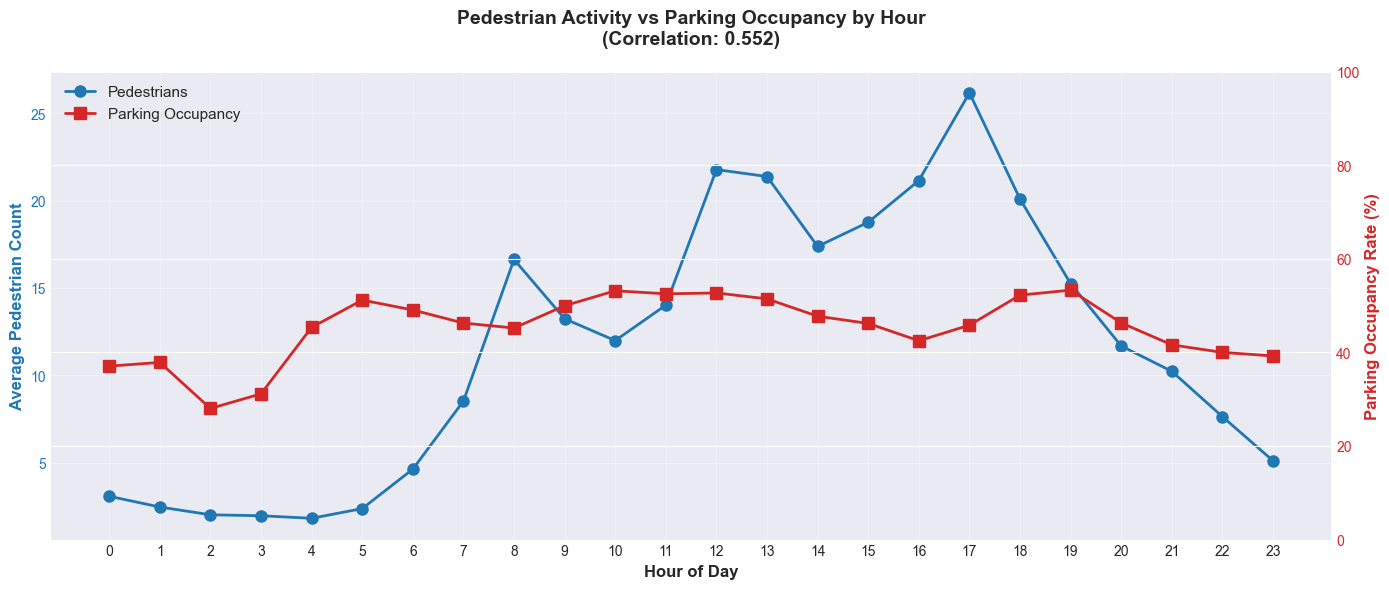


✅ Correlation chart saved as 'pedestrian_vs_parking_correlation.png'


In [13]:
# Cell 13: BONUS - Correlation between pedestrian activity and parking occupancy

# Load pedestrian data for comparison
pedestrian_df = pd.read_csv(r"C:\Users\ertugrul\Downloads\Supabase Snippet Pedestrian Counts with Sensor Locations.csv")
pedestrian_df['melbourne_time'] = pd.to_datetime(pedestrian_df['melbourne_time'])
pedestrian_df['date'] = pd.to_datetime(pedestrian_df['date'])
pedestrian_df['hour'] = pd.to_numeric(pedestrian_df['hour'], errors='coerce')

# Aggregate pedestrian data by hour
pedestrian_hourly = pedestrian_df.groupby('hour')['pedestrian_count'].mean().reset_index()
pedestrian_hourly.columns = ['hour', 'avg_pedestrian_count']

# Aggregate parking data by hour
parking_hourly = df.groupby('hour')['is_occupied'].mean().reset_index()
parking_hourly.columns = ['hour', 'avg_occupancy_rate']
parking_hourly['avg_occupancy_rate'] = parking_hourly['avg_occupancy_rate'] * 100

# Merge datasets
comparison = pd.merge(pedestrian_hourly, parking_hourly, on='hour')

# Calculate correlation
correlation = comparison['avg_pedestrian_count'].corr(comparison['avg_occupancy_rate'])

print("=" * 70)
print("🔗 PEDESTRIAN vs PARKING CORRELATION ANALYSIS")
print("=" * 70)
print(f"Correlation coefficient: {correlation:.3f}")
print(f"Interpretation: {'Strong positive' if correlation > 0.7 else 'Moderate positive' if correlation > 0.4 else 'Weak'} correlation")
print("\nThis means pedestrian activity and parking demand {'move together' if correlation > 0.4 else 'are not strongly related'}.")

# Visualize correlation
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Pedestrian Count', color=color, fontsize=12, fontweight='bold')
ax1.plot(comparison['hour'], comparison['avg_pedestrian_count'], 
         marker='o', color=color, linewidth=2, markersize=8, label='Pedestrians')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(0, 24))

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Parking Occupancy Rate (%)', color=color, fontsize=12, fontweight='bold')
ax2.plot(comparison['hour'], comparison['avg_occupancy_rate'], 
         marker='s', color=color, linewidth=2, markersize=8, label='Parking Occupancy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 100)

plt.title(f'Pedestrian Activity vs Parking Occupancy by Hour\n(Correlation: {correlation:.3f})', 
          fontsize=14, fontweight='bold', pad=20)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)

plt.tight_layout()
plt.savefig('pedestrian_vs_parking_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Correlation chart saved as 'pedestrian_vs_parking_correlation.png'")

In [15]:
import plotly.graph_objects as go
import pandas as pd

# Assuming you have a DataFrame with parking bay data
# df = pd.read_csv('parking_bays.csv')  # Load your data

# Create the map visualization
fig = go.Figure(go.Scattermapbox(
    lat=df['latitude'],
    lon=df['longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=8,
        color='rgb(242, 177, 172)',
        opacity=0.7
    ),
    text=df.index,  # or any other column for hover text
    hoverinfo='text'
))

fig.update_layout(
    mapbox=dict(
        accesstoken='pk.eyJ1IjoiZXJ0dWdydWxha2RlbWlyIiwiYSI6ImNtZ3o0NXVsOTAyOXk3cHM4ZHJ0MmU1enMifQ.vj7BMAX9VFQbNGaqt9ixdQ',  # Replace with your Mapbox token
        style='dark',
        center=dict(
            lat=df['latitude'].mean(),
            lon=df['longitude'].mean()
        ),
        zoom=12
    ),
    title='Parking Bays Visualization',
    height=700,
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.show()

In [16]:
# Cell 14: Load ALL parking bays metadata (not just active ones)

# Load the full parking bays table
PARKING_BAYS_CSV = r"C:\Users\ertugrul\Downloads\parking_bays_rows.csv"  # Replace with your file path

parking_bays_all = pd.read_csv(PARKING_BAYS_CSV)

print("=" * 70)
print("🅿️ ALL PARKING BAYS METADATA")
print("=" * 70)
print(f"Total parking bays in database: {len(parking_bays_all):,}")
print(f"Unique kerbside IDs: {parking_bays_all['kerbsideid'].nunique()}")
print(f"\nFirst 5 rows:")
print(parking_bays_all.head())

# Clean coordinates
parking_bays_all['latitude'] = pd.to_numeric(parking_bays_all['latitude'], errors='coerce')
parking_bays_all['longitude'] = pd.to_numeric(parking_bays_all['longitude'], errors='coerce')

# Remove bays without coordinates
parking_bays_all = parking_bays_all.dropna(subset=['latitude', 'longitude'])

print(f"\nParking bays with valid coordinates: {len(parking_bays_all):,}")
print(f"Parking bays in sensor data: {df['kerbsideid'].nunique()}")
print(f"Missing from sensor data: {len(parking_bays_all) - df['kerbsideid'].nunique()}")

🅿️ ALL PARKING BAYS METADATA
Total parking bays in database: 1,129
Unique kerbside IDs: 230

First 5 rows:
   id  roadsegmentid  kerbsideid  \
0   1          23322         NaN   
1   2          22124         NaN   
2   3          21024         NaN   
3   4          22283         NaN   
4   5          22714         NaN   

                              roadsegmentdescription   latitude   longitude  \
0  Docklands Drive between Docklands Drive and We... -37.816117  144.935611   
1  Hartley Street between Lorimer Street and West... -37.824272  144.940202   
2    Little Lothian Street South from Lothian Street -37.804181  144.944707   
3                 Fairlie Court from Anderson Street -37.832744  144.984957   
4  Anderson Street between Acland Street and Fair... -37.833043  144.983878   

  lastupdated                               location  \
0  2023-10-31  {"lat":-37.8161166,"lon":144.9356111}   
1  2023-10-31  {"lat":-37.8242724,"lon":144.9402022}   
2  2023-10-31   {"lat":-37.804181

In [19]:
# Cell 15: Map of ALL unique parking bay locations (deduplicated by coordinates)

import plotly.graph_objects as go

# Get unique lat/lon combinations (not unique kerbsideid)
unique_locations = parking_bays_all[['latitude', 'longitude']].drop_duplicates()

print(f"📍 Mapping {len(unique_locations):,} unique parking bay LOCATIONS...")
print(f"   (Note: {len(parking_bays_all):,} total rows in database)")
print(f"   (Some locations have multiple parking types/restrictions)")

# Merge back to get one representative row per location
parking_map_data = parking_bays_all.merge(
    unique_locations,
    on=['latitude', 'longitude'],
    how='right'
).drop_duplicates(subset=['latitude', 'longitude'])

# Create hover text with first available street name
parking_map_data['hover_text'] = parking_map_data.apply(
    lambda row: f"<b>Location:</b> {row['roadsegmentdescription']}<br>" +
                f"<b>Lat:</b> {row['latitude']:.6f}<br>" +
                f"<b>Lon:</b> {row['longitude']:.6f}",
    axis=1
)

# Create map with smaller dots (to match the density in the screenshot)
fig = go.Figure(go.Scattermapbox(
    lat=parking_map_data['latitude'],
    lon=parking_map_data['longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=4,  # Smaller dots like in screenshot
        color='rgb(255, 100, 100)',  # Red dots
        opacity=0.7
    ),
    text=parking_map_data['hover_text'],
    hoverinfo='text',
    name='Parking Locations'
))

fig.update_layout(
    mapbox=dict(
        accesstoken='pk.eyJ1IjoiZXJ0dWdydWxha2RlbWlyIiwiYSI6ImNtZ3o0NXVsOTAyOXk3cHM4ZHJ0MmU1enMifQ.vj7BMAX9VFQbNGaqt9ixdQ',
        style='dark',
        center=dict(
            lat=parking_map_data['latitude'].mean(),
            lon=parking_map_data['longitude'].mean()
        ),
        zoom=13  # Closer zoom to match screenshot
    ),
    title=f'All Melbourne Parking Bay Locations ({len(unique_locations):,} unique spots)',
    height=700,
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.show()
fig.write_html('all_parking_locations_map.html')
print("✅ All parking locations map saved!")
print(f"🔴 Red dots = {len(unique_locations):,} unique parking locations")

📍 Mapping 1,129 unique parking bay LOCATIONS...
   (Note: 1,129 total rows in database)
   (Some locations have multiple parking types/restrictions)


✅ All parking locations map saved!
🔴 Red dots = 1,129 unique parking locations


In [20]:
# Cell 16: Compare parking bays WITH sensor data vs WITHOUT

# Get bays that have sensor readings
active_bays = set(df['kerbsideid'].unique())
all_bays = set(parking_bays_all['kerbsideid'].unique())

# Find bays without sensor data
inactive_bays = all_bays - active_bays

print("=" * 70)
print("📊 PARKING BAY ACTIVITY COMPARISON")
print("=" * 70)
print(f"Total parking bays in database: {len(all_bays):,}")
print(f"Bays with sensor readings (Oct 28-29): {len(active_bays):,}")
print(f"Bays WITHOUT sensor readings: {len(inactive_bays):,}")
print(f"Activity coverage: {len(active_bays)/len(all_bays)*100:.1f}%")

# Create visualization showing both
active_bay_coords = parking_bays_all[parking_bays_all['kerbsideid'].isin(active_bays)]
inactive_bay_coords = parking_bays_all[parking_bays_all['kerbsideid'].isin(inactive_bays)]

fig = go.Figure()

# Add active bays (green)
fig.add_trace(go.Scattermapbox(
    lat=active_bay_coords['latitude'],
    lon=active_bay_coords['longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=6,
        color='rgb(50, 205, 50)',  # Green for active
        opacity=0.7
    ),
    text=[f"Bay ID: {kid}<br>Status: Active" for kid in active_bay_coords['kerbsideid']],
    hoverinfo='text',
    name=f'Active Bays ({len(active_bays):,})'
))

# Add inactive bays (red)
fig.add_trace(go.Scattermapbox(
    lat=inactive_bay_coords['latitude'],
    lon=inactive_bay_coords['longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=6,
        color='rgb(255, 69, 0)',  # Red for inactive
        opacity=0.5
    ),
    text=[f"Bay ID: {kid}<br>Status: No Data" for kid in inactive_bay_coords['kerbsideid']],
    hoverinfo='text',
    name=f'Inactive Bays ({len(inactive_bays):,})'
))

fig.update_layout(
    mapbox=dict(
        accesstoken='pk.eyJ1IjoiZXJ0dWdydWxha2RlbWlyIiwiYSI6ImNtZ3o0NXVsOTAyOXk3cHM4ZHJ0MmU1enMifQ.vj7BMAX9VFQbNGaqt9ixdQ',
        style='dark',
        center=dict(
            lat=parking_bays_all['latitude'].mean(),
            lon=parking_bays_all['longitude'].mean()
        ),
        zoom=12
    ),
    title='Active vs Inactive Parking Bays (Oct 28-29, 2025)',
    height=700,
    margin={"r":0,"t":40,"l":0,"b":0},
    showlegend=True
)

fig.show()
fig.write_html('active_vs_inactive_parking_bays.html')
print("✅ Comparison map saved as 'active_vs_inactive_parking_bays.html'")
print(f"🟢 Green dots = Bays with sensor data ({len(active_bays):,})")
print(f"🔴 Red dots = Bays without sensor data ({len(inactive_bays):,})")

📊 PARKING BAY ACTIVITY COMPARISON
Total parking bays in database: 231
Bays with sensor readings (Oct 28-29): 1,916
Bays WITHOUT sensor readings: 151
Activity coverage: 829.4%


✅ Comparison map saved as 'active_vs_inactive_parking_bays.html'
🟢 Green dots = Bays with sensor data (1,916)
🔴 Red dots = Bays without sensor data (151)
